### Deep Q-Network (DQN) Agent

Deep Q-Network (DQN) is a reinforcement learning algorithm that uses a neural network `QNetwork` to approximate the optimal action-value function:

```math
Q(s, a) = \mathbb{E}[r + \gamma \max_{a'} Q(s', a') | s, a]
```

To do this, the algorithm uses two neural networks: a local network and a target network. The local network is updated during the training process while the target network is used to compute targets during the training process. This approach address the moving target problem, where updates to the network cause targets to shift, potentially leading to oscillations or divergence in the training process.

To train the local network, the algorithm computes $Q_{\theta}(s,a)$ using the local network and the algorithm computes a target value $Q_{\text{target}} = r + \gamma \max_{a'} Q_{\theta'}(s',a')$ using the target network. Although these targets may not be very accurate at the beginning of the training process, the reward $r$ in the formula and regular soft updates from the local network to the target network gradually move the learning process in the right direction.

Now, the local network is trained by minimizing the difference between the predicted Q-values and the target Q-values:

```math
L(\theta) = \mathbb{E}_{(s, a, r, s') \sim \mathcal{D}} \left[ \left( r + \gamma \max_{a'} Q_{\theta'}(s', a') - Q_\theta(s, a) \right)^2 \right]
```

Here, $\gamma$ is the discount factor; $\theta$ and $\theta'$ represent the parameters of the local network and target networks, respectively; and $\mathcal{D}$ denotes the replay buffer that stores experience tuples $(s, a, r, s')$ for training.

In the following implementation, the loss is computed in `Agent.learn`:

```python
Q_targets_next = self.QNetwork_target(next_states).detach()
Q_targets = rewards.unsqueeze(1) + (self.gamma * Q_targets_next * (1 - dones.unsqueeze(1)))
Q_predicted = self.QNetwork_local(states).gather(1, actions)
loss = self.criterion(Q_predicted, Q_targets)
```

Directly afterwards, the network is updated via gradient descent:

```python
self.optimizer.zero_grad()
loss.backward()
self.optimizer.step()
```

Furthermore, soft updates are regularly pushed from the local network to the target network every $n$ steps to improve the accuracy of the targets:

```python
for param_target, param_local in zip(self.QNetwork_target.parameters(), self.QNetwork_local.parameters()):
            param_target.data.copy_(self.tau * param_local.data + (1.0 - self.tau) * param_target.data)
```

In practice, instead of training the network on consecutive state transitions, which can cause correlations in updates and inefficient learning, DQN uses a `ReplayBuffer` for experience replay. This approach randomly samples past experiences, thereby breaking correlations and improving learning efficiency:

```python
experiences = random.sample(self.memory, k=self.batch_size)
```

---

#### Further Enhancements To Implementation:

**Duelling DQN**

A `DuelingQNetwork` is an enhancement to the `QNetwork` architecture that separates $Q(s,a) = V(s) + A(s,a)$ into two streams to predict state values $V(s)$ and to predict action advantages $A(s,a)$ (how action $a$ compares to other actions in state $s$). To ensure that $A$ is centered around 0/avoid redundant information/etc., we use $Q(s,a) = V(s) + (A(s,a) - \text{mean}_{a}A(s,a))$.

```python
class DuelingQNetwork(nn.Module):

    def __init__(self, n_obs_dim: int, n_action_dim: int, n_hidden_1_dim=64, n_hidden_2_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(n_obs_dim, n_hidden_1_dim)
        self.fc2 = nn.Linear(n_hidden_1_dim, n_hidden_2_dim)
        
        self.value_stream = nn.Sequential(
            nn.Linear(n_hidden_2_dim, 1)
        )
        
        self.advantage_stream = nn.Sequential(
            nn.Linear(n_hidden_2_dim, n_action_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        value = self.value_stream(x)

        advantage = self.advantage_stream(x)
        
        Q_value = value + (advantage - advantage.mean(dim=1, keepdim=True))

        return Q_value
```

**Double DQN** 

Double DQN improves upon standard DQN by using the policy network for action selection and the target network for action evaluation, reducing overestimation bias in Q-value estimates: 

```python
next_actions = self.QNetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
Q_targets_next = self.QNetwork_target(next_states).gather(1, next_actions).detach()
Q_targets = rewards.unsqueeze(1) + (self.gamma * Q_targets_next * (1 - dones.unsqueeze(1)))
```

---

The full implementation of the algorithm is below.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DuelingQNetwork(nn.Module):
    """ A Deep Q-Network:
    
       A feedforward neural network that models the Q-value function.

        Args:
            n_obs_dim (int): The dimensionality of the observation space.
            n_action_dim (int): The dimensionality of the action space.
            n_hidden_1_dim (int, optional): The number of nodes in hidden layer #1. Default is 128.
            n_hidden_2_dim (int, optional): The number of nodes in hidden layer #2. Default is 128.
    
    """

    def __init__(self, n_obs_dim: int, n_action_dim: int, n_hidden_1_dim=128, n_hidden_2_dim=128):
        super(DuelingQNetwork, self).__init__()
        self.fc1 = nn.Linear(n_obs_dim, n_hidden_1_dim)
        self.fc2 = nn.Linear(n_hidden_1_dim, n_hidden_2_dim)
        
        # value stream
        self.value_stream = nn.Sequential(
            nn.Linear(n_hidden_2_dim, 1)
        )
        
        # advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(n_hidden_2_dim, n_action_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        value = self.value_stream(x)

        advantage = self.advantage_stream(x)
        
        # Q(s,a) = V(s) + A(s,a)
        Q_value = value + (advantage - advantage.mean(dim=1, keepdim=True))

        return Q_value

In [2]:
from collections import deque
import numpy as np
import random

class ReplayBuffer:
    """ A Replay Buffer:

        Args:
            buffer_size (int): Number of experiences to store.
            batch_size (int): Number of experiences to sample for training.

        Attributes:
            memory (deque): A deque to store experiences.
            batch_size (int): Number of experiences to sample for training.

        Methods:

            store(experience: tuple[np.ndarray, int, float, np.ndarray, bool]) -> None:
                Store an experience.

            sample() -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
                Randomly sample a batch of experiences for training.
     
    """

    def __init__(self, buffer_size: int, batch_size: int):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def store(self, experience: tuple[np.ndarray, int, float, np.ndarray, bool]) -> None:
        """
            Store an experience.

            Args:
                experience (tuple[np.ndarray, int, float, np.ndarray, bool]): An experience.

        """
        self.memory.append(experience)

    def sample(self) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
            Randomly sample a batch of experiences for training.

            Returns: 
                tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: A batch of experiences for training.

        """
        
        experiences = random.sample(self.memory, k=self.batch_size) # randomly (not sequentially because markov property) sample k experiences from memory
        # note: this is an off-policy algorithm since the agent is learning from experiences from different versions of the policy

        states, actions, rewards, next_states, dones = zip(*experiences)

        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(np.array(actions), dtype=torch.int64)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(np.array(dones), dtype=torch.float32)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

In [3]:
class Agent:
    """ A Deep Q-Network (DQN) Agent:

        Args:
            n_obs_dim (int): The dimensionality of the observation space.
            n_action_dim (int): The dimensionality of the action space.
            alpha (float, optional): Learning Rate. Default is 1e-3.
            gamma (float, optional): Discount Factor. Default is 0.99.
            tau (float, optional): Soft Update Coefficient. Default is 1e-3.
            eps (float, optional): Epsilon. Default is 1.0.
            eps_min (float, optional): Minimum Epsilon. Default is 0.01.
            eps_decay (float, optional): Decay rate for Epsilon. Default is 0.995.
            delay (int, optional): TD Delay. Default is 4.
            buffer_size (int, optional): Buffer Size. Default is 10000.
            batch_size (int, optional): Batch Size. Default is 64.

        Attributes:
            alpha (float): Learning Rate.
            gamma (float): Discount Factor.
            tau (float): Soft Update Coefficient.
            eps (float): Epsilon.
            eps_min (float): Minimum Epsilon.
            eps_decay (float): Decay Rate for Epsilon.
            delay (int): TD Delay.
            count (int): TD Counter.
            memory (ReplayBuffer): Replay Buffer.
            QNetwork_local (DuelingQNetwork): Local Q-Network.
            QNetwork_target (DuelingQNetwork): Target Q-Network.
            optimizer (torch.optim.Optimizer): Optimizer
            criterion (torch.nn.Module): Criterion.

        Methods:

            step(experience: tuple[np.ndarray, int, float, np.ndarray, bool]) -> None:
                Step the agent.

            act(state: np.ndarray) -> int:
                Performs action selection using an epsilon-greedy exploration strategy.

            learn() -> None:
                Update the local Q-Network using experiences randomly sampled from memory.

            soft_update() -> None:
                Soft update to target Q-Network.
            
    """
    
    def __init__(self, obs_space: int, act_space: int, alpha= 1e-3, gamma=0.99, tau=1e-3, eps=1.0, eps_min=0.01, eps_decay=0.995, delay=4, buffer_size=10000, batch_size=64):

        # set hyperparameters
        self.alpha = alpha      # learning rate
        self.gamma = gamma      # discount factor
        self.tau = tau          # soft update coefficient

        # epsilon-greedy exploration
        self.eps = eps
        self.eps_min = eps_min
        self.eps_decay = eps_decay

        # temporal difference
        self.delay = delay
        self.count = 0

        self.memory = ReplayBuffer(buffer_size, batch_size)

        self.QNetwork_local = DuelingQNetwork(obs_space, act_space)
        self.QNetwork_target = DuelingQNetwork(obs_space, act_space)
        self.QNetwork_target.load_state_dict(self.QNetwork_local.state_dict())

        self.optimizer = torch.optim.AdamW(self.QNetwork_local.parameters(), lr=self.alpha)
        self.criterion = nn.MSELoss()

    def step(self, experience: tuple[np.ndarray, int, float, np.ndarray, bool]) -> None:
        """
            Step the agent.

            Args:
                experience (tuple[np.ndarray, int, float, np.ndarray, bool]): An experience.

        """

        # save to replay buffer
        self.memory.store(experience)

        # learn after specified number of steps
        self.count = (self.count + 1) % self.delay
        if (self.count == 0) and (len(self.memory) > self.memory.batch_size):
            self.learn()

    def act(self, state: np.ndarray) -> int:
        """
            Performs action selection using an epsilon-greedy exploration strategy.

            Args:
            state (np.ndarray): An observation.

            Returns:
                int: The selected action.

        """
        state = torch.from_numpy(state).float().unsqueeze(0)

        with torch.no_grad():
            self.QNetwork_local.eval()
            Q_values = self.QNetwork_local(state)
            self.QNetwork_local.train()

        if random.random() < self.eps:
            return random.choice(np.arange(self.QNetwork_local.advantage_stream[0].out_features)) # exploration
        else:
            return np.argmax(Q_values.numpy()) # exploitation

    def learn(self) -> None:
        """
            Update the local Q-Network using experiences randomly sampled from memory.

        """

        # sample memory
        states, actions, rewards, next_states, dones = self.memory.sample()
        actions = actions.unsqueeze(1)

        # note: use local network for action selection to reduce overestimation bias
        next_actions = self.QNetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
        Q_targets_next = self.QNetwork_target(next_states).gather(1, next_actions).detach()

        Q_targets = rewards.unsqueeze(1) + (self.gamma * Q_targets_next * (1 - dones.unsqueeze(1)))
        Q_predicted = self.QNetwork_local(states).gather(1, actions)

        # L(θ) = (Q_target - Q(s,a;θ))^2
        loss = self.criterion(Q_predicted, Q_targets)
        
        # backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network
        self.soft_update()

        # decay epsilon
        self.eps = max(self.eps_min, self.eps * self.eps_decay)

    def soft_update(self) -> None:
        """ θ_target ← τ * θ_local + (1 - τ) * θ_target """

        # weighted update of the parameters of the target network from the parameters of the policy network
        for param_target, param_local in zip(self.QNetwork_target.parameters(), self.QNetwork_local.parameters()):
            param_target.data.copy_(self.tau * param_local.data + (1.0 - self.tau) * param_target.data)


In [4]:
import gymnasium as gym

# initialize environment
env = gym.make('LunarLander-v2', render_mode='rgb_array')

obs_space = env.observation_space.shape[0]
act_space = env.action_space.n

print(f'LunarLander-v2 Environment')
print(f' Observation Space:', obs_space)
print(f' Action Space:', act_space)

LunarLander-v2 Environment
 Observation Space: 8
 Action Space: 4


In [5]:
import imageio

# initialize agent
agent = Agent(obs_space, act_space)

n_average = 50
reward_hist = []
frames = []

n_trajectories = 800
for i in range(1, n_trajectories + 1):

    state = env.reset()[0]
    total_reward = 0

    T = 1000
    for t in range(T):

        if i % (n_average * 2) == 0:
            frame = env.render()
            frames.append(frame)

        # select action
        action = agent.act(state)

        # get feedback from environment
        next_state, reward, terminated, truncated, _ = env.step(action) 
        done = terminated or truncated
        agent.step((state, action, reward, next_state, done))
        total_reward += reward
        state = next_state

        # terminate (if needed)
        if done:
            break
    
    reward_hist.append(total_reward)

    if i % n_average == 0:
        avg_reward = np.mean(reward_hist[-n_average:])
        print(f'Episode {i}/{n_trajectories} | Average Reward: {avg_reward:.2f}')

Episode 50/800 | Average Reward: -257.01
Episode 100/800 | Average Reward: -232.27
Episode 150/800 | Average Reward: -90.60
Episode 200/800 | Average Reward: -103.87
Episode 250/800 | Average Reward: -75.87
Episode 300/800 | Average Reward: -59.96
Episode 350/800 | Average Reward: -35.29
Episode 400/800 | Average Reward: -41.86
Episode 450/800 | Average Reward: -12.92
Episode 500/800 | Average Reward: -8.90
Episode 550/800 | Average Reward: 82.78
Episode 600/800 | Average Reward: 91.67
Episode 650/800 | Average Reward: 182.45
Episode 700/800 | Average Reward: 193.89
Episode 750/800 | Average Reward: 219.13
Episode 800/800 | Average Reward: 175.83


In [6]:
# save
torch.save(agent.QNetwork_target.state_dict(), 'DQN.pth')

In [7]:
imageio.mimsave('./GIF/DQN.GIF', frames, fps=45)

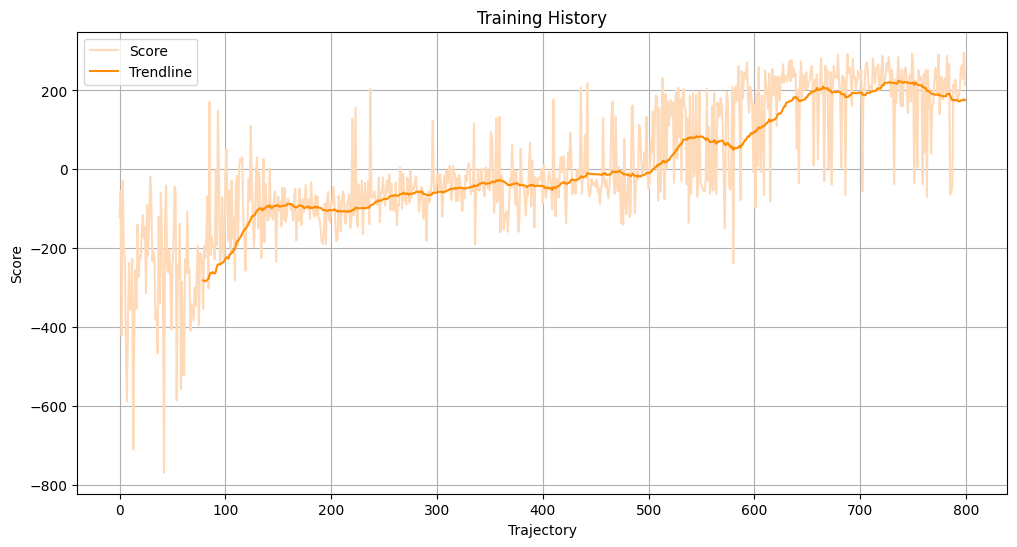

In [18]:
import matplotlib.pyplot as plt

trendline = np.convolve(reward_hist, np.ones(n_average)/n_average, mode='valid')

# plot results
plt.figure(figsize=(12, 6))
plt.plot(reward_hist, label='Score', color='#FFDAB9')
plt.plot(range(n_average-1, len(reward_hist)), trendline, label='Trendline', color='#FF8C00')
plt.title('Training History')
plt.xlabel('Trajectory')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()